# Chapter 9: Tensorflow

#### Description:

* Tensorflow is an open source library for Machine Learning.
* On a basic level, it allows the user to define computation graphs.
* It evaluates the graph computation using optimized C++ code that is parallelizable across multiple CPUs and/or GPUs.

#### Advantages:

* It is highly cross-device compatible: Linux, Windows, MacOS, Android and iOS are supported.
* It is well designed, scalable and highly optimized (including automatic differentiating 'autodiff' that calculates the gradient of the cost function one designs).
* It also comes with a visualization tool called TensorBoard that allows you to browse through the computation graph, view learning curves, etc...

## Basics

### Initializing the graph

In [1]:
import tensorflow as tf

# Create variables
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

# Option 1
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

# Option 2 (note: closing the session is unnecesary)
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)
    
# Option 3 (note: global variables initializer)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    result = f.eval()
    print(result)

# Option 4 (note: interactive session sets default session as the created object)
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

Instructions for updating:
Colocations handled automatically by placer.
42
42
42
42


#### Note:
* It is important to set the default session.
* All created nodes (variables, functions) are added automatically to the graph / session.
* Sessions have construction, execution and closing steps.

### Managing multiple graphs

In [2]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


### Dependencies

* Tensorflow automatically detects node dependencies.
* All node values are dropped between graph runs, except variable values, which are maintained by the session across graph runs.
* If you want to evaluate y and z efficiently, without evaluating w and x twice as in the previous code, you must ask TensorFlow to evaluate both y and z in just one graph run.

In [3]:
w = tf.constant(3) 
x=w+2 
y=x+5 
z=x*3

# Running separate evaluations
with tf.Session() as sess: 
    print(y.eval()) # 10 
    print(z.eval()) # 15
    
# Reusing node evaluations
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z]) 
    print(y_val) # 10 
    print(z_val) # 15

10
15
10
15


### Operations

* Nodes in the graph are called ops.
* Constants and variables take no input are called source ops.
* The inputs and outputs are multidimensional arrays, called tensors.

## Normal equation with TF

* Reminder: $\hat \theta = (X^T X)^{-1} X^T y$

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Import dataset
housing = pd.read_csv(os.path.join('', "housing.csv"))
m, n = housing.shape

# Encode string values
encoder = LabelEncoder()
housing["ocean_proximity"] = encoder.fit_transform(housing["ocean_proximity"])

# Separate X from y
target = housing["median_house_value"]
housing.drop(["median_house_value"], axis=1, inplace=True)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing = scaler.fit_transform(housing)
target = scaler.fit_transform(target.reshape(-1,1))

# Add bias
housing = np.c_[np.ones((m, 1)), housing]

# Remove nulls
imputer = SimpleImputer(strategy="median")
housing = imputer.fit_transform(housing)
target = imputer.fit_transform(target)

# Separate train and test set
X_train, X_test, y_train, y_test = train_test_split(housing, target, test_size=0.25, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [5]:
X = tf.constant(X_train, dtype=tf.float32, name="X")
y = tf.constant(y_train, dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess: 
    theta_value = theta.eval()

pred = np.dot(X_test, theta_value)

In [6]:
from sklearn.metrics import r2_score
print("Accuracy", r2_score(y_test,pred))

Accuracy 0.6266166130920349


## Gradient Descent with TF

In [16]:
def gd_tf(X_train, y_train, n_epochs=1000, learning_rate=0.01, DEBUG=False):
    m, n = X_train.shape
    X = tf.constant(X_train, dtype=tf.float32, name="X")
    y = tf.constant(y_train, dtype=tf.float32, name="y")
    theta = tf.Variable(tf.random_uniform([n, 1], -1.0, 1.0), name="theta")

    y_pred = tf.matmul(X, theta, name="predictions")
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    gradients = 2/m * tf.matmul(tf.transpose(X), error)

    training_op = tf.assign(theta, theta - learning_rate * gradients)
    
    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            if epoch%100 == 0 and DEBUG:
                print("Epoch", epoch, "MSE =", mse.eval())
            sess.run(training_op)
        best_theta = theta.eval()
        best_mse = mse.eval()
    return best_theta, best_mse

best_theta, best_mse = gd_tf(X_train, y_train, 2000)

print("MSE", best_mse)

MSE 0.3667774


## Optmimizing Gradient Descent with TF

#### Note

* There are many useful optimizers: GradientDescent (classic), MomentumOptimizer (often works faster), and more.

In [17]:
from tensorflow.train import GradientDescentOptimizer

def gd_tf_opt(X_train, y_train, n_epochs=1000, learning_rate=0.01, DEBUG=False):
    m, n = X_train.shape
    X = tf.constant(X_train, dtype=tf.float32, name="X")
    y = tf.constant(y_train, dtype=tf.float32, name="y")
    theta = tf.Variable(tf.random_uniform([n, 1], -1.0, 1.0), name="theta")

    y_pred = tf.matmul(X, theta, name="predictions")
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
    # Optmimizer comes in
    optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(mse)

    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            if epoch%100 == 0 and DEBUG:
                print("Epoch", epoch, "MSE =", mse.eval())
            sess.run(training_op)
        best_theta = theta.eval()
        best_mse = mse.eval()
    return best_theta, best_mse

best_theta, best_mse = gd_tf_opt(X_train, y_train, 2000)

print("MSE", best_mse)

MSE 0.3676985


## Implemeting mini-batches and Tensorboard visualization

In [72]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

def fetch_batch(X_train, y_train, epoch, batch_index, batch_size): 
    np.random.seed(epoch+batch_index)
    idxs = np.random.randint(0, high=len(X_train)-1, size=batch_size)
    return X_train[idxs], y_train[idxs]

def gd_tf_batch(X_train, y_train, n_epochs=20, n_batches=100, batch_size=100, learning_rate=0.01, DEBUG=False):
    m, n = X_train.shape
    X = tf.placeholder(tf.float32, shape=(None,n), name="X")
    y = tf.placeholder(tf.float32, shape=(None,1), name="y")
    theta = tf.Variable(tf.random_uniform([n, 1], -1.0, 1.0), name="theta")

    y_pred = tf.matmul(X, theta, name="predictions")
    with tf.name_scope("loss") as scope:
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    
    optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(mse)
    
    mse_summary = tf.summary.scalar('MSE', mse)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            for batch in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train, y_train, epoch, batch, batch_size)
                if batch%50 == 0 and DEBUG:
                    summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                    file_writer.add_summary(summary_str, epoch * n_batches + batch)
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        best_theta = theta.eval()
        best_mse = mse.eval(feed_dict={X:X_train, y:y_train})
    
    file_writer.close()
    return best_theta, best_mse

best_theta, best_mse = gd_tf_batch(X_train, y_train, DEBUG=True)

print("MSE", best_mse)

MSE 0.3664601


## Modularity

In [58]:
tf.reset_default_graph() # reset the graph

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold") # reuse existing variable
        m, n = X.get_shape() # X is placeholder, shape: m x n
        w_shape = (int(n), 1) # shape: m x 1
        w = tf.Variable(tf.random_normal(w_shape), name="weights") 
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="relu")

def example_relu(X_data):
    X = tf.constant(X_data, dtype=tf.float32, name="X")
    with tf.variable_scope("relu"): # create the variable
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
    relus = [relu(X) for i in range(5)]
    output = tf.add_n(relus, name="output")
    return output

with tf.Session() as sess:
    example = example_relu(X_train) # construct the graph
    sess.run(tf.global_variables_initializer()) # initialize the variables
    print("Output", example.eval()) # run graph

Output [[ 3.255662 ]
 [ 5.2415156]
 [ 8.18939  ]
 ...
 [ 4.474133 ]
 [ 4.6314554]
 [10.633579 ]]


## Logistic regression

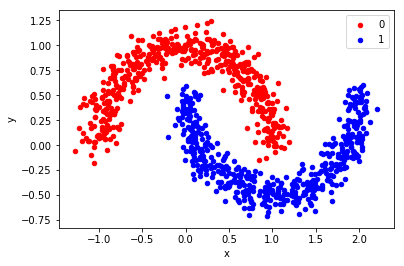

In [196]:
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.datasets import make_moons

X_moon, y_moon = make_moons(n_samples=1000, noise=0.1)
df = DataFrame(dict(x=X_moon[:,0], y=X_moon[:,1], label=y_moon))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [237]:
def logistic_regression(X_train, 
                        y_train, 
                        n_epochs=20, 
                        n_batches=100, 
                        batch_size=100, 
                        learning_rate=0.01, 
                        DEBUG=False):
    m, n = X_train.shape
    _, k = y_train.shape
    X = tf.placeholder(tf.float32, shape=(None,n), name="X")
    y = tf.placeholder(tf.float32, shape=(None,k), name="y")
    theta = tf.Variable(tf.random_uniform((n, k), -1.0, 1.0), name="theta")
    b = tf.Variable(tf.zeros((1, k)))

    with tf.name_scope("pred") as scope:
        y_pred = tf.nn.softmax(tf.matmul(X,theta) + b) # Softmax
    
    with tf.name_scope("loss") as scope:
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_pred), reduction_indices=1), name="cross_entropy")

    optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(cross_entropy)

    c_e_summary = tf.summary.scalar('cross_entropy', cross_entropy)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            for batch in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train, y_train, epoch, batch, batch_size)
                if batch%50 == 0 and DEBUG:
                    summary_str = c_e_summary.eval(feed_dict={X: X_train, y: y_train})
                    file_writer.add_summary(summary_str, epoch * n_batches + batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        y_ans_softmax, theta_ans, c_entropy_ans = sess.run([
                y_pred,
                theta,
                cross_entropy], feed_dict={X: X_train, y: y_train})
        y_ans = tf.argmax(input=y_ans_softmax, axis=1).eval()
    file_writer.close()
    return {"predictions": y_ans, "theta": theta_ans, "cross_entropy": c_entropy_ans}

In [240]:
from sklearn.preprocessing import OneHotEncoder
y_moon_encoded = OneHotEncoder(categories='auto').fit_transform(y_moon.reshape(-1,1)).toarray()
ans = logistic_regression(X_moon,y_moon_encoded, DEBUG=True)

In [239]:
print("Labels", y_moon[:10])
print("Predictions", ans["predictions"][:10])
print("Cross Entropy", ans["cross_entropy"])

Labels [0 1 1 1 0 0 0 1 1 0]
Predictions [0 1 1 1 0 0 0 1 1 0]
Cross Entropy 0.29997435
